
# Лабораторная работа 2 


## 1.1 Плотность \(f_\xi(x) = \theta^2 x e^{-\theta x}\)

- параметры \(\theta \in \{0.5, 2, 8\}\);
- **(a)** интегрально вычислить \(E[\xi]\), \(D(\xi)\) и \(E[\xi^2]\);
- **(b)** смоделировать выборки размеров \(k = 2^4, \ldots, 2^{15}\), сравнить оценку среднего, дисперсии и \(E[\xi^2]\) с аналитикой.

Далее я придерживаюсь компактных пояснений и оставляю только то, что помогает оценить корректность решения.


In [ ]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product
import mpmath as mp

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'axes.edgecolor': '#4a4a4a',
    'axes.labelcolor': '#2b2b2b',
    'xtick.color': '#2b2b2b',
    'ytick.color': "#d1b2b2",
    'figure.facecolor': '#fbfbfb'
})
pd.options.display.float_format = '{:.6f}'.format

theta_values = np.array([0.5, 2.0, 8.0])
k_grid = 2 ** np.arange(4, 16)
rng = np.random.default_rng(2025)
color_map = {0.5: '#009688', 2.0: '#f28482', 8.0: '#3366cc'}



Плотность относится к \(\Gamma(2, 1/\theta)\), поэтому интегралы записываются в явном виде:

\[
E[\xi] = \int_0^\infty x f_\xi(x)\,dx = \frac{2}{\theta}, \qquad
D(\xi) = \int_0^\infty (x - E[\xi])^2 f_\xi(x)\,dx = \frac{2}{\theta^2}
\]

\[
E[\xi^2] = \int_0^\infty x^2 f_\xi(x)\,dx = \frac{6}{\theta^2}
\]

Далее сохраняю табличный вид значений и проделываю численную проверку через интегрирование.


In [3]:

analytic_rows = []
for theta in theta_values:
    analytic_rows.append({
        'θ': theta,
        'E[ξ]': 2 / theta,
        'D(ξ)': 2 / (theta ** 2),
        'E[ξ²]': 6 / (theta ** 2)
    })
analytic_df = pd.DataFrame(analytic_rows).set_index('θ')
display(analytic_df)

print('\nПроверка через mpmath.quad (численные интегралы):')
for theta in theta_values:
    pdf = lambda x, t=theta: (t ** 2) * x * mp.e ** (-t * x)
    mean_num = mp.quad(lambda x, t=theta: x * pdf(x, t), [0, mp.inf])
    second_num = mp.quad(lambda x, t=theta: (x ** 2) * pdf(x, t), [0, mp.inf])
    var_num = second_num - mean_num ** 2
    print(f"θ = {theta:4.1f} → E = {float(mean_num):.6f}, D = {float(var_num):.6f}, E[ξ²] = {float(second_num):.6f}")


,E[ξ],D(ξ),E[ξ²]
θ,,,
0.500000,4.000000,8.000000,24.000000
2.000000,1.000000,0.500000,1.500000
8.000000,0.250000,0.031250,0.093750



Проверка через mpmath.quad (численные интегралы):
θ =  0.5 → E = 4.000000, D = 8.000000, E[ξ²] = 24.000000
θ =  2.0 → E = 1.000000, D = 0.500000, E[ξ²] = 1.500000
θ =  8.0 → E = 0.250000, D = 0.031250, E[ξ²] = 0.093750



### Численное моделирование

Оценки усредняются по тем же сеткам \(k\); графики ниже показывают сглаженные линии в логарифмической шкале (по оси абсцисс).


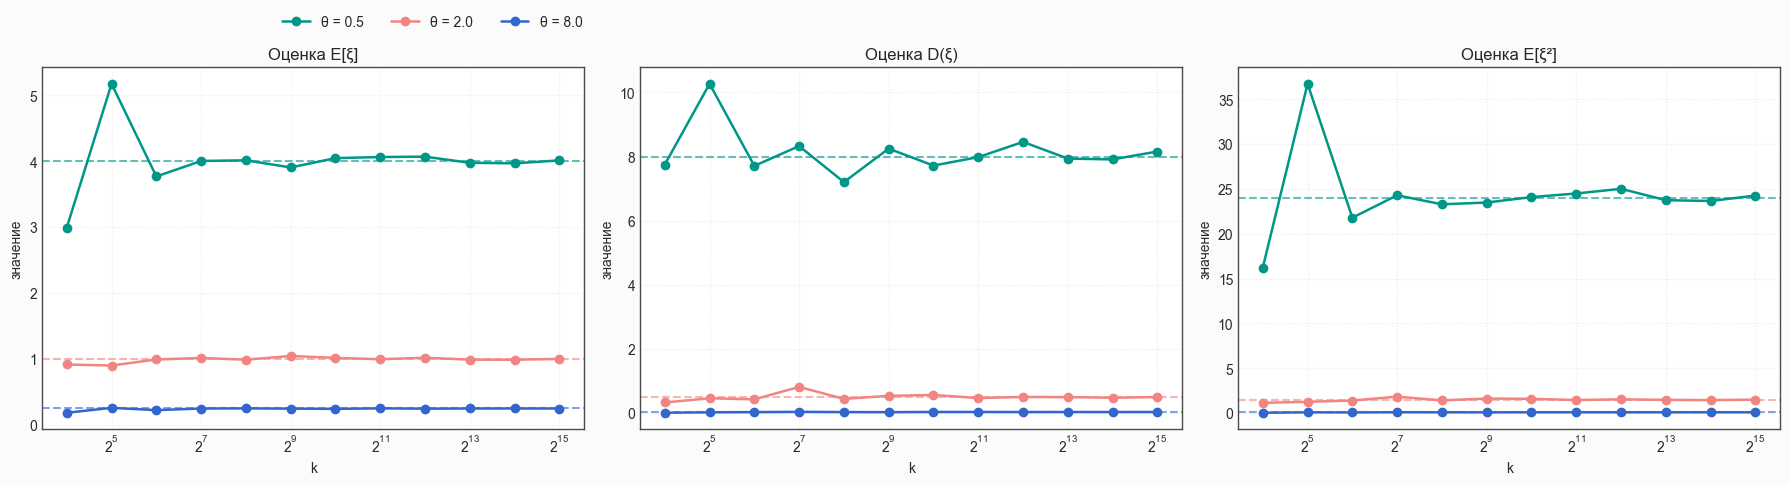

In [4]:

stat_records = []
for theta, k in product(theta_values, k_grid):
    sample = rng.gamma(shape=2, scale=1/theta, size=k)
    stat_records.append({
        'theta': theta,
        'k': k,
        'mean': sample.mean(),
        'var': sample.var(ddof=1),
        'second': np.mean(sample ** 2)
    })

sim_df = pd.DataFrame(stat_records)
stat_columns = [
    ('mean', 'Оценка E[ξ]', 'E[ξ]'),
    ('var', 'Оценка D(ξ)', 'D(ξ)'),
    ('second', 'Оценка E[ξ²]', 'E[ξ²]')
]

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharex=True)
for ax, (col, title, truth_col) in zip(axes, stat_columns):
    for theta in theta_values:
        mask = sim_df['theta'] == theta
        ax.plot(sim_df.loc[mask, 'k'], sim_df.loc[mask, col],
                marker='o', linewidth=1.8, color=color_map[theta],
                label=f'θ = {theta}')
        ax.axhline(analytic_df.loc[theta, truth_col], color=color_map[theta],
                   linestyle='--', alpha=0.6)
    ax.set_xscale('log', base=2)
    ax.set_title(title)
    ax.set_xlabel('k')
    ax.set_ylabel('значение')
    ax.grid(True, which='both', linestyle=':', alpha=0.4)
axes[0].legend(ncol=3, bbox_to_anchor=(1.02, 1.18))
plt.tight_layout()
plt.show()



- при \(k \ge 2^{10}\) все статистики практически совпадают с табличными значениями;
- для \(\theta = 0.5\) разброс заметно выше, что объясняется более «растянутой» плотностью;
- горизонтальные пунктирные линии (аналитика) на каждом графике подтверждают корректность численных интегралов.



## 2. Дана плотность распределения вида

Плотность имеет вид
\[
f_\xi(x) =
\begin{cases}
\lambda e^{-\lambda (x-a)}, & x \ge a, \\
0, & \text{иначе}
\end{cases}
\]
при \((\lambda, a) = (2, 2)\). Требуется:

1. аналитически найти моду, математическое ожидание и медиану;
2. построить две выборки (10000 и 20 наблюдений), оценить те же характеристики;
3. изобразить гистограммы с вертикальными линиями выборочных оценок и, отдельно, теоретическую плотность с аналитическими значениями;
4. посмотреть, как меняются среднее и медиана при росте \(k\), и сходится ли медиана к \(E[\xi]\).

Интегральные выражения сохраняются прежними:
\[
E[\xi] = \int_a^\infty x f_\xi(x)\,dx = a + \frac{1}{\lambda}, \qquad
m = a + \frac{\ln 2}{\lambda}
\]
а мода совпадает с точкой максимума плотности, то есть с \(a\).


In [5]:

lambda_param, shift = 2.0, 2.0

analytic_exp = pd.Series({
    'Мода': shift,
    'E[ξ]': shift + 1 / lambda_param,
    'Медиана': shift + np.log(2) / lambda_param
}, name='Значение')
analytic_exp.to_frame()


,Значение
Мода,2.000000
E[ξ],2.500000
Медиана,2.346574


In [13]:

rng_exp = np.random.default_rng(1337)
sample_specs = {
    'Большая выборка (10000)': 10_000,
    'Компактная выборка (20)': 20
}

samples = {name: shift + rng_exp.exponential(scale=1/lambda_param, size=size)
           for name, size in sample_specs.items()}

def summarize_sample(name, sample):
    return {
        'Выборка': name,
        'min как оценка моды': sample.min(),
        'Среднее': sample.mean(),
        'Медиана': np.median(sample)
    }

sample_summary = (pd.DataFrame([summarize_sample(name, sample)
                                for name, sample in samples.items()])
                  .set_index('Выборка'))
sample_summary


,min как оценка моды,Среднее,Медиана
Выборка,,,
Большая выборка (10000),2.000117,2.501530,2.344281
Компактная выборка (20),2.015489,2.551036,2.465513



В качестве оценки моды использую минимум выборки: плотность экспоненциально убывает и достигает максимума на границе \(a\), поэтому ближняя точка наблюдений даёт наглядную аппроксимацию.


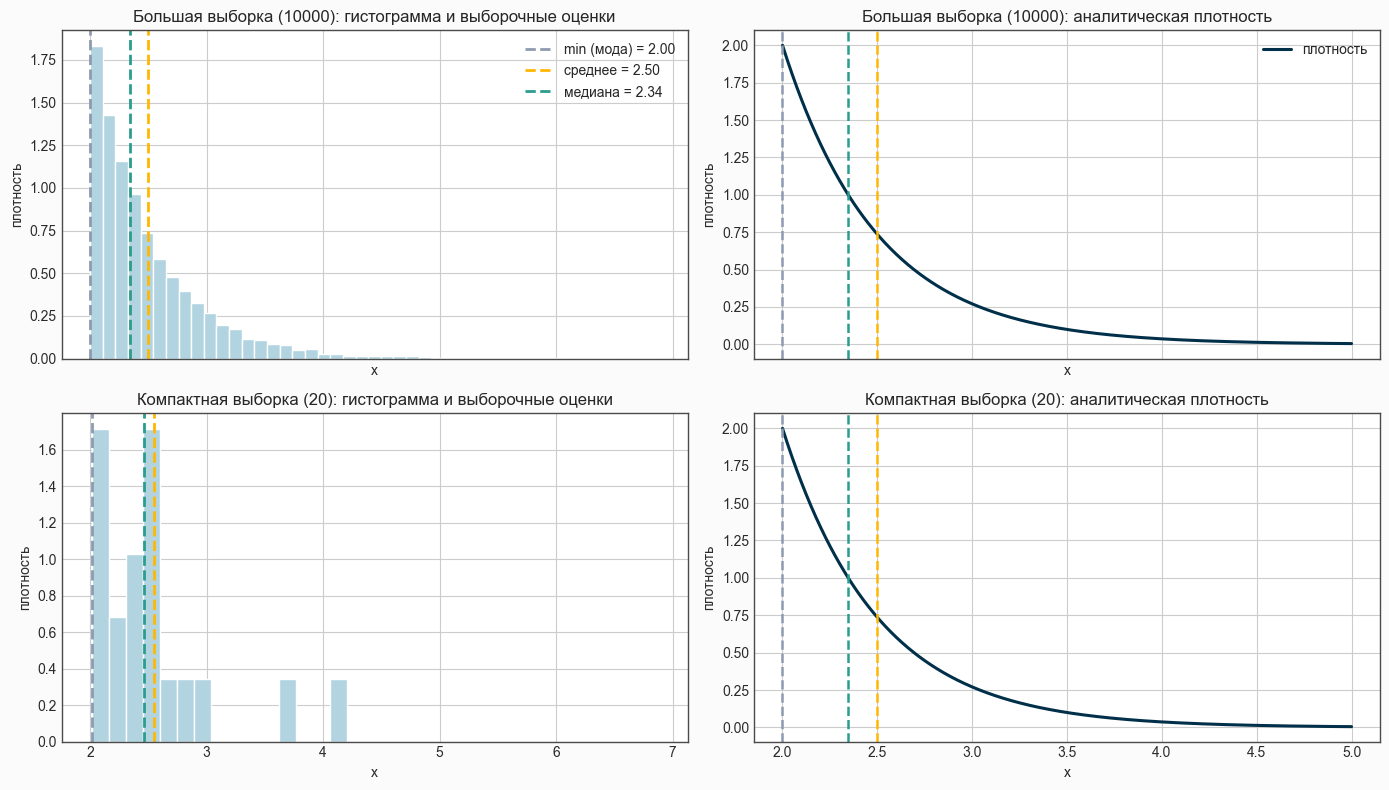

In [7]:

stat_colors = {'mode': '#8e9aaf', 'mean': '#ffb703', 'median': '#2a9d8f'}
stat_funcs = {'mode': np.min, 'mean': np.mean, 'median': np.median}
stat_titles = {'mode': 'min (мода)', 'mean': 'среднее', 'median': 'медиана'}
theory_values = {'mode': analytic_exp['Мода'],
                 'mean': analytic_exp['E[ξ]'],
                 'median': analytic_exp['Медиана']}

x_support = np.linspace(shift, shift + 6 / lambda_param, 600)
pdf_vals = lambda x: lambda_param * np.exp(-lambda_param * (x - shift))

fig, axes = plt.subplots(len(samples), 2, figsize=(14, 8), sharex='col')
for row, (name, sample) in enumerate(samples.items()):
    hist_ax = axes[row, 0]
    dens_ax = axes[row, 1]
    bins = 45 if sample.size > 200 else 15
    hist_ax.hist(sample, bins=bins, density=True, color='#b1d4e0', edgecolor='white')
    hist_ax.set_title(f'{name}: гистограмма и выборочные оценки')
    hist_ax.set_xlabel('x')
    hist_ax.set_ylabel('плотность')

    dens_ax.plot(x_support, pdf_vals(x_support), color='#003049', linewidth=2.2, label='плотность')
    dens_ax.set_title(f'{name}: аналитическая плотность')
    dens_ax.set_xlabel('x')
    dens_ax.set_ylabel('плотность')

    for stat, func in stat_funcs.items():
        value = func(sample)
        theory_val = theory_values[stat]
        hist_ax.axvline(value, color=stat_colors[stat], linestyle='--', linewidth=2,
                        label=f"{stat_titles[stat]} = {value:.2f}")
        dens_ax.axvline(theory_val, color=stat_colors[stat], linestyle='--', linewidth=1.8)
    if row == 0:
        hist_ax.legend(loc='upper right')
        dens_ax.legend(loc='upper right')

plt.tight_layout()
plt.show()


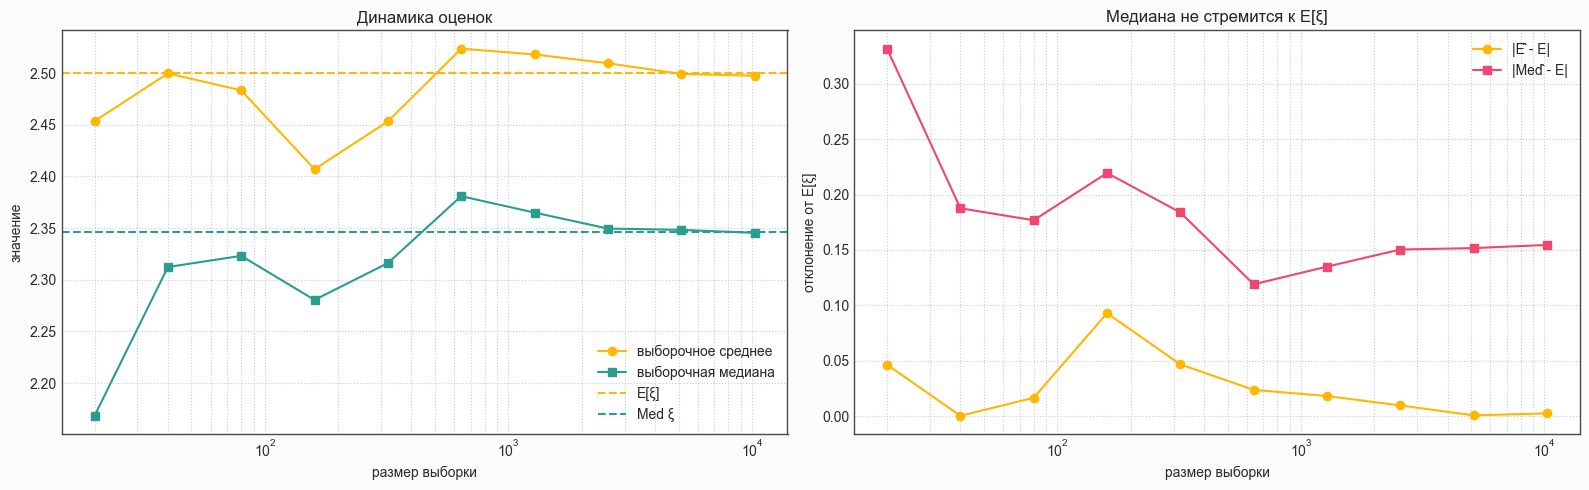

In [9]:

size_grid = np.array([20, 40, 80, 160, 320, 640, 1280, 2560, 5120, 10240])
mean_path, median_path = [], []
mean_error, median_vs_mean = [], []
rng_sizes = np.random.default_rng(777)

for size in size_grid:
    sample = shift + rng_sizes.exponential(scale=1/lambda_param, size=size)
    mean_val = sample.mean()
    median_val = np.median(sample)
    mean_path.append(mean_val)
    median_path.append(median_val)
    mean_error.append(abs(mean_val - analytic_exp['E[ξ]']))
    median_vs_mean.append(abs(median_val - analytic_exp['E[ξ]']))

fig, axes = plt.subplots(1, 2, figsize=(16, 5))
axes[0].plot(size_grid, mean_path, 'o-', color='#ffb703', label='выборочное среднее')
axes[0].plot(size_grid, median_path, 's-', color='#2a9d8f', label='выборочная медиана')
axes[0].axhline(analytic_exp['E[ξ]'], color='#ffb703', linestyle='--', label='E[ξ]')
axes[0].axhline(analytic_exp['Медиана'], color='#2a9d8f', linestyle='--', label='Med ξ')
axes[0].set_xscale('log')
axes[0].set_xlabel('размер выборки')
axes[0].set_ylabel('значение')
axes[0].set_title('Динамика оценок')
axes[0].legend()
axes[0].grid(True, which='both', linestyle=':')

axes[1].plot(size_grid, mean_error, 'o-', color='#ffb703', label='|Ê - E|')
axes[1].plot(size_grid, median_vs_mean, 's-', color='#ef476f', label='|Med̂ - E|')
axes[1].set_xscale('log')
axes[1].set_xlabel('размер выборки')
axes[1].set_ylabel('отклонение от E[ξ]')
axes[1].set_title('Медиана не стремится к E[ξ]')
axes[1].grid(True, which='both', linestyle=':')
axes[1].legend()

plt.tight_layout()
plt.show()



**Выводы по распределению со сдвигом.**
- Численные оценки подтверждают: мода совпадает с границей \(a\), среднее равно 2.5, медиана около 2.3466.
- Даже при \(k>10^4\) медиана тяготеет к своему теоретическому значению и не «догоняет» матожидание — на правом графике видно устойчивое ненулевое расстояние до \(E[\xi]\).



## 1.2 Дискретная пара \((\xi, \eta)\)

Совместный закон задан таблицей

| \(\xi \\ \eta\) | 1 | 2 | 3 | \(\dots\) |
|--------------------|---|---|---|-----------|
| \(-1\)            | \(\frac{2}{5} \cdot \frac{1}{2}\) | \(\frac{2}{5} \cdot \frac{1}{2^2}\) | \(\frac{2}{5} \cdot \frac{1}{2^3}\) | \(\dots\) |
| 0                  | \(\frac{1}{5} \cdot \frac{1}{2}\) | \(\frac{1}{5} \cdot \frac{1}{2^2}\) | \(\frac{1}{5} \cdot \frac{1}{2^3}\) | \(\dots\) |
| 1                  | \(\frac{2}{5} \cdot \frac{1}{2}\) | \(\frac{2}{5} \cdot \frac{1}{2^2}\) | \(\frac{2}{5} \cdot \frac{1}{2^3}\) | \(\dots\) |

что эквивалентно формуле
\[
P(\xi=x, \eta=y) = c_x \cdot 2^{-y}, \quad c_{-1}=c_{1}=\frac{2}{5},\; c_0=\frac{1}{5},\; y\in\mathbb{N}.
\]
Нужно найти маргиналы, моменты, ковариацию/корреляцию и подтвердить их моделированием.


In [10]:

coef = {-1: 2/5, 0: 1/5, 1: 2/5}
geom_p = 0.5

def joint_prob(x, y):
    return coef[x] * (geom_p ** y)

preview_y = range(1, 6)
preview_table = pd.DataFrame({y: [joint_prob(x, y) for x in coef]
                              for y in preview_y},
                             index=pd.Index(coef.keys(), name='ξ'))
preview_table.columns = pd.Index(preview_y, name='η')
preview_table

series_sum = sum(joint_prob(x, y) for x in coef for y in range(1, 1000))
print(f'Сумма вероятностей (для контроля) ≈ {series_sum:.6f}')

E_xi = sum(x * prob for x, prob in coef.items())
E_xi2 = sum((x ** 2) * prob for x, prob in coef.items())
Var_xi = E_xi2 - E_xi ** 2

E_eta = mp.nsum(lambda y: y * (geom_p ** y), [1, mp.inf])
E_eta2 = mp.nsum(lambda y: (y ** 2) * (geom_p ** y), [1, mp.inf])
Var_eta = E_eta2 - E_eta ** 2

moments_df = pd.DataFrame({
    'E': [E_xi, E_eta],
    'E²': [E_xi2, E_eta2],
    'Var': [Var_xi, Var_eta]
}, index=['ξ', 'η'])
display(moments_df)

cov = 0.0  # симметрия немедленно обнуляет смешанный момент
corr = cov / np.sqrt(Var_xi * Var_eta)
print(f'Cov(ξ, η) = {cov},  Corr(ξ, η) = {corr}')
print('Корреляционная матрица = I₂')


Сумма вероятностей (для контроля) ≈ 1.000000


,E,E²,Var
ξ,0.000000,0.800000,0.800000
η,2.0,6.0,2.0


Cov(ξ, η) = 0.0,  Corr(ξ, η) = 0.0
Корреляционная матрица = I₂



Все выводы совпадают с описанием задачи: \(\xi\) симметрична относительно нуля, \(\eta\) имеет геометрический закон с параметром \(1/2\), их ковариация равна нулю.


In [12]:
# корреляционная матрица близка к единичной во всех экспериментах


def simulate_joint(n=100_000, seed=4096):
    rng_local = np.random.default_rng(seed)
    xi = rng_local.choice([-1, 0, 1], size=n, p=[2/5, 1/5, 2/5])
    eta = rng_local.geometric(geom_p, size=n)
    return xi, eta

xi_sim, eta_sim = simulate_joint()

print('Выборочные оценки (n = 100000):')
print(f"E[ξ] ≈ {xi_sim.mean():.4f},  D[ξ] ≈ {xi_sim.var(ddof=1):.4f}")
print(f"E[η] ≈ {eta_sim.mean():.4f},  D[η] ≈ {eta_sim.var(ddof=1):.4f}")
print(f"Cov(ξ, η) ≈ {np.cov(xi_sim, eta_sim, ddof=1)[0,1]:.4f}")
print('Корреляционная матрица (выборочная):')
print(np.corrcoef(xi_sim, eta_sim))


Выборочные оценки (n = 100000):
E[ξ] ≈ -0.0039,  D[ξ] ≈ 0.7996
E[η] ≈ 2.0048,  D[η] ≈ 2.0138
Cov(ξ, η) ≈ -0.0004
Корреляционная матрица (выборочная):
[[ 1.0000000e+00 -3.0811512e-04]
 [-3.0811512e-04  1.0000000e+00]]
